In [1]:
#!pip install torchtext

In [2]:
#!pip install transformers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.legacy import data
from torchtext import datasets

from transformers import RobertaTokenizer, RobertaModel

import numpy as np

import time
import random
import functools


In [4]:
# hyperparameters & setup

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DROPOUT = 0.2
N_EPOCHS = 60
BATCH_SIZE = 2
LEARNING_RATE = 0.8e-6
NO_HEAD_TRANS = 16

TAG_LOSS_WEIGTH = 0.1
CLS_LOSS_WEIGTH = 1

BERT_PATH = './roberta-large' # the path of your downloaded pre-trained language model
DATA_PATH = './gap-data/'

tokenizer = RobertaTokenizer.from_pretrained(BERT_PATH)
bert = RobertaModel.from_pretrained(BERT_PATH)


Some weights of the model checkpoint at ./roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# define pre-processing

def read_token_idx_list_n_cut_to_max_length(tokens, max_input_length):
    
    tokens =  tokens[:max_input_length-1]
    tokens_list = []
    for i in tokens:
        tokens_list.append(int(i))
    return torch.tensor(tokens_list)

def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

pad_token = tokenizer.pad_token
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
max_input_length = tokenizer.max_model_input_sizes['roberta-large']
text_id_preprocessor = functools.partial(read_token_idx_list_n_cut_to_max_length,max_input_length = max_input_length)
tag_preprocessor = functools.partial(cut_to_max_length, max_input_length = max_input_length)


In [6]:
# prepare dataset

TOKEN = data.Field(batch_first = True)
TOKEN_ID = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
LABEL1 = data.Field(batch_first = True,
                    unk_token = None,
                    preprocessing = tag_preprocessor)
MASK = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
FT_TAGS = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
SEQ = data.Field(batch_first = True)
LABEL2 = data.Field(batch_first = True,
                    unk_token = None,
                    preprocessing = tag_preprocessor)

fields = (("token", TOKEN),
          ('token_id', TOKEN_ID),
          ('label1', LABEL1),
          ('mask', MASK),
          ('first_token', FT_TAGS),
          ('seq', SEQ),
          ('label2', LABEL2))

train_data, valid_data, test_data = data.TabularDataset.splits(
                                    path = DATA_PATH,
                                    train = 'gap_train_new.csv',
                                    validation = 'gap_dev_new.csv',
                                    test = 'gap_test_new.csv',
                                    format = 'csv',
                                    fields = fields,
                                    skip_header = True)

TOKEN.build_vocab(train_data, valid_data, test_data)
LABEL1.build_vocab(train_data, valid_data, test_data)
FT_TAGS.build_vocab(train_data, valid_data, test_data)
SEQ.build_vocab(train_data, valid_data, test_data)
LABEL2.build_vocab(train_data, valid_data, test_data)

# if you want to prepare a big vocabulary that covers words that never appear in your dataset:

#word_list = [['<unk>', '<pad>', 'I', 'great', "it's", 'like', 'swimming', '.', ',', 'BBBBBBB']]
#TOKEN.build_vocab(word_list)


In [7]:
print('Example:', vars(train_data.examples[2]))
print('Label1 vocab', LABEL1.vocab.itos)
print('Label2 vocab', LABEL2.vocab.itos)


Example: {'token': ['<s>', 'Z', 'oe', 'ĠTel', 'ford', 'Ġ--', 'Ġplayed', 'Ġthe', 'Ġpolice', 'Ġofficer', 'Ġgirlfriend', 'Ġof', 'ĠSimon', ',', 'ĠMaggie', '.', 'ĠD', 'umped', 'Ġby', 'ĠSimon', 'Ġin', 'Ġthe', 'Ġfinal', 'Ġepisode', 'Ġof', 'Ġseries', 'Ġ1', ',', 'Ġafter', 'Ġhe', 'Ġslept', 'Ġwith', 'ĠJenny', ',', 'Ġand', 'Ġis', 'Ġnot', 'Ġseen', 'Ġagain', '.', 'ĠPh', 'oe', 'be', 'ĠThomas', 'Ġplayed', 'ĠCheryl', 'ĠCassidy', ',', 'ĠPaul', 'ine', "'s", 'Ġfriend', 'Ġand', 'Ġalso', 'Ġa', 'Ġyear', 'Ġ11', 'Ġpupil', 'Ġin', 'ĠSimon', "'s", 'Ġclass', '.', 'ĠD', 'umped', 'Ġher', 'Ġboyfriend', 'Ġfollowing', 'ĠSimon', "'s", 'Ġadvice', 'Ġafter', 'Ġhe', 'Ġwouldn', "'t", 'Ġhave', 'Ġsex', 'Ġwith', 'Ġher', 'Ġbut', 'Ġlater', 'Ġrealised', 'Ġthis', 'Ġwas', 'Ġdue', 'Ġto', 'Ġhim', 'Ġcatching', 'Ġcrabs', 'Ġoff', 'Ġher', 'Ġfriend', 'ĠPaul', 'ine', '.', '</s>'], 'token_id': tensor([    0,  1301,  3540,  5477,  1891,   480,   702,     5,   249,  1036,
         6096,     9,  4616,     6, 18320,     4,   211, 25844,    30,  

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    shuffle = True,
    sort=False)


cuda


In [9]:
class MTL(nn.Module):
    def __init__(self,bert,label1_output_dim,label2_output_dim,dropout,no_head_trans):
        
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.dropout = nn.Dropout(dropout)
        self.tag_layer1 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        self.cls_layer1 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        self.tag_layer2 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        self.cls_layer2 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.tag_layer3 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.cls_layer3 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.tag_layer4 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.cls_layer4 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        
        self.fc_tag = nn.Linear(embedding_dim, label1_output_dim)
        self.fc_cls = nn.Linear(embedding_dim, label2_output_dim)
        
    def forward(self, token_id, mask):
        
        emb_share = self.dropout(self.bert(token_id)[0]) # [batch size, seq len, emb dim]
        
        tag1 = self.dropout(self.tag_layer1(emb_share))  # [batch size, seq len, emb dim]
        cls1 = self.dropout(self.cls_layer1(emb_share))    # [batch size, seq len, emb dim]
        tag2 = self.dropout(self.tag_layer2(tag1))  # [batch size, seq len, emb dim]
        cls2 = self.dropout(self.cls_layer2(cls1))    # [batch size, seq len, emb dim]
        # tag3 = self.dropout(self.tag_layer3(tag2))  # [batch size, seq len, emb dim]
        # cls3 = self.dropout(self.cls_layer3(cls2))    # [batch size, seq len, emb dim]
        # tag4 = self.dropout(self.tag_layer4(tag2))  # [batch size, seq len, emb dim]
        # cls4 = self.dropout(self.cls_layer4(cls3))    # [batch size, seq len, emb dim]
        
        tag_pred = self.fc_tag(tag2) # [batch size, seq len, output dim]
        cls_mask_out = torch.sum(cls2*mask.unsqueeze(2),1) # [batch size, output dim]
        cls_pred = self.fc_cls(cls_mask_out)
        
        return tag_pred, cls_pred
    

In [10]:
OUTPUT_DIM_TAGGING = len(LABEL1.vocab)
OUTPUT_DIM_CLASSIFICATION = len(LABEL2.vocab)

print(OUTPUT_DIM_TAGGING)
print(OUTPUT_DIM_CLASSIFICATION)

model = MTL(bert,
            OUTPUT_DIM_TAGGING, 
            OUTPUT_DIM_CLASSIFICATION, 
            DROPOUT,
            NO_HEAD_TRANS)

print(f'The model has {count_parameters(model):,} trainable parameters')


3
3
The model has 388,965,382 trainable parameters


In [11]:
bert_params = []
other_params = []
for name, param in model.named_parameters():
  if name.startswith("bert"):
    bert_params.append(param)
  else:
    other_params.append(param)

In [12]:
len(bert_params)

391

In [13]:
len(other_params)

52

In [14]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        if name.startswith("bert"):
            print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [15]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        if not name.startswith("bert"):
            print(name)

tag_layer1.self_attn.in_proj_weight
tag_layer1.self_attn.in_proj_bias
tag_layer1.self_attn.out_proj.weight
tag_layer1.self_attn.out_proj.bias
tag_layer1.linear1.weight
tag_layer1.linear1.bias
tag_layer1.linear2.weight
tag_layer1.linear2.bias
tag_layer1.norm1.weight
tag_layer1.norm1.bias
tag_layer1.norm2.weight
tag_layer1.norm2.bias
cls_layer1.self_attn.in_proj_weight
cls_layer1.self_attn.in_proj_bias
cls_layer1.self_attn.out_proj.weight
cls_layer1.self_attn.out_proj.bias
cls_layer1.linear1.weight
cls_layer1.linear1.bias
cls_layer1.linear2.weight
cls_layer1.linear2.bias
cls_layer1.norm1.weight
cls_layer1.norm1.bias
cls_layer1.norm2.weight
cls_layer1.norm2.bias
tag_layer2.self_attn.in_proj_weight
tag_layer2.self_attn.in_proj_bias
tag_layer2.self_attn.out_proj.weight
tag_layer2.self_attn.out_proj.bias
tag_layer2.linear1.weight
tag_layer2.linear1.bias
tag_layer2.linear2.weight
tag_layer2.linear2.bias
tag_layer2.norm1.weight
tag_layer2.norm1.bias
tag_layer2.norm2.weight
tag_layer2.norm2.bia

In [16]:
from transformers.optimization import (
    get_linear_schedule_with_warmup, get_constant_schedule, get_constant_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup,
get_cosine_schedule_with_warmup)

TAG_PAD_IDX = LABEL1.vocab.stoi[LABEL1.pad_token]

criterion_tag = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
criterion_cls = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)



model = model.to(device)
criterion_tag = criterion_tag.to(device)
criterion_cls = criterion_cls.to(device)

#optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

optimizer = optim.Adam(
    [
        {"params": bert_params, "lr": 0.9*LEARNING_RATE},
        {"params": other_params},
    ],
    lr=LEARNING_RATE,
)

# optimizer = optim.Adam(
#     [
#         {"params": bert_params, "lr": 2*LEARNING_RATE}
#         {"params": other_params}
#     ],
#     lr=LEARNING_RATE,
# )


In [17]:
# for name, param in model.bert.named_parameters():                
#     if name.startswith('embeddings'):
#         param.requires_grad = False

In [18]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [19]:
for name, param in model.bert.named_parameters():                
    if param.requires_grad:
        print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [20]:
def obtain_tagging_pred_n_true(preds, y, tag_pad_idx, org_shap, fist_tokens, FT_TAGS):

    max_preds_p = preds.argmax(dim = 1, keepdim = True).view(org_shap)
    y_p = y.view(org_shap)
    fist_tokens_p = fist_tokens.view(org_shap)
   
    preds_list = []
    true_list = []
    for i in range(len(y_p)):
        seq_pred = []
        seq_true = []
        for j in range(len(y_p[i])):

            if y_p[i][j].item() != tag_pad_idx and fist_tokens_p[i][j] == 1:
                seq_pred.append(max_preds_p[i][j].item()-1)
                seq_true.append(y_p[i][j].item()-1)

        preds_list.append(seq_pred)
        true_list.append(seq_true)

    return preds_list, true_list

def obtain_classification_pred_n_true(preds, y):

    max_preds = preds.argmax(dim = 1)
   
    preds_list = []
    true_list = []
    for i in range(len(y)):
        preds_list.append(max_preds[i].item()-1)
        true_list.append(y[i].item()-1)

    return preds_list, true_list

def f1_score_tag(preds_list, true_list):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(true_list)):
        for j in range(len(true_list[i])):
            if true_list[i][j] == 1:
                if preds_list[i][j] == 1:
                    tp+=1
                elif preds_list[i][j] == 0:
                    fn += 1
            elif true_list[i][j] == 0:
                if preds_list[i][j] == 0:
                    tn += 1
                elif preds_list[i][j] == 1:
                    fp += 1
               
    recall = tp/(tp+fn+1e-9)
    precision = tp/(tp+fp+1e-9)
    f1 = 2*recall*precision/(recall+precision+1e-9)
    acc = (tp+tn)/(tp+tn+fp+fn+1e-9)
    return round(precision,4), round(recall,4), round(f1,4), round(acc,4)

def f1_score_cls(preds_list, true_list):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(true_list)):
        if true_list[i] == 1:
            if preds_list[i] == 1:
                tp+=1
            elif preds_list[i] == 0:
                fn += 1
        elif true_list[i] == 0:
            if preds_list[i] == 0:
                tn += 1
            elif preds_list[i] == 1:
                fp += 1
               
    recall = tp/(tp+fn+1e-9)
    precision = tp/(tp+fp+1e-9)
    f1 = 2*recall*precision/(recall+precision+1e-9)
    acc = (tp+tn)/(tp+tn+fp+fn+1e-9)
    return round(precision,4), round(recall,4), round(f1,4), round(acc,4)

def train(model, iterator, optimizer, criterion_label, criterion_pos, tag_pad_idx, tag_loss_weight, cls_loss_weight):
    
    loss_label1 = 0
    loss_label2 = 0
    
    model.train()
    
    pred_label1_list=[]
    true_label1_list=[]
    pred_label2_list=[]
    true_label2_list=[]
    
    for batch in iterator:
        
        org_label1_shap = batch.label1.size() # [batch size, seq len]
        org_label2_shap = batch.label2.size() # [batch size, 1]
        
        token_idx_ = batch.token_id # [batch size, seq len]
        mask_ = batch.mask # [batch size, seq len]
        ft_tags = batch.first_token.view(-1) # [batch size * seq len]
        tag_true = batch.label1.view(-1) # [batch size * seq len]
        cls_true = batch.label2.view(-1) # [batch size]
        
        optimizer.zero_grad()
        
        # tag_pred:[batch size, seq len, label1 dim]
        # cls_pred:[batch size, label2 dim]
        tag_pred, cls_pred = model(token_idx_,mask_)

        tag_pred = tag_pred.view(-1, tag_pred.shape[-1]) # [batch size * seq len, label1 dim]

        loss_tag = criterion_tag(tag_pred, tag_true)
        loss_cls = criterion_cls(cls_pred, cls_true)
        
        loss_label1 += loss_tag.item()
        loss_label2 += loss_cls.item()
        
        # loss_tag is larger than loss_cls, so the overall loss is weighted summed up.
        # if loss_cls > loss_tag*10:
        #     cls_loss_weight=0.1
        # elif loss_cls > loss_tag*5:
        #     cls_loss_weight=0.2
        # elif loss_cls > loss_tag*2:
        #     cls_loss_weight=0.5
        # elif loss_cls < loss_tag*0.5:
        #     cls_loss_weight=2
        
        # tag_loss_weight=1
        # cls_loss_weight=tag_loss_weight*loss_tag/loss_cls
        
        
        loss = tag_loss_weight*loss_tag + cls_loss_weight*loss_cls
        
        loss.backward()
        
        optimizer.step()
        
        pred_label1, true_label1 = obtain_tagging_pred_n_true(tag_pred, tag_true, tag_pad_idx, org_label1_shap, ft_tags, FT_TAGS)
        pred_label2, true_label2 = obtain_classification_pred_n_true(cls_pred, cls_true)
        
        
        pred_label1_list.extend(pred_label1)
        true_label1_list.extend(true_label1)
        pred_label2_list.extend(pred_label2)
        true_label2_list.extend(true_label2)
            
            
    p_label1, r_label1, f_label1, acc_label1 = f1_score_tag(pred_label1_list, true_label1_list)
    p_label2, r_label2, f_label2, acc_label2 = f1_score_cls(pred_label2_list, true_label2_list)
        
    return round(loss_label1,4), round(loss_label2,4), p_label1, r_label1, f_label1, acc_label1, p_label2, r_label2, f_label2, acc_label2

def evaluate(model, iterator, criterion_label, criterion_pos, tag_pad_idx):
    
    loss_label1 = 0
    loss_label2 = 0
    
    model.eval()

    with torch.no_grad():

        pred_label1_list=[]
        true_label1_list=[]
        pred_label2_list=[]
        true_label2_list=[]
        
        for batch in iterator:

            org_label1_shap = batch.label1.size() # [batch size, seq len]
            org_label2_shap = batch.label2.size() # [batch size, 1]

            token_idx_ = batch.token_id # [batch size, seq len]
            mask_ = batch.mask # [batch size, seq len]
            ft_tags = batch.first_token.view(-1) # [batch size * seq len]
            tag_true = batch.label1.view(-1) # [batch size * seq len]
            cls_true = batch.label2.view(-1) # [batch size]

            # tag_pred:[batch size, seq len, label1 dim]
            # cls_pred:[batch size, label2 dim]
            tag_pred, cls_pred = model(token_idx_,mask_)

            tag_pred = tag_pred.view(-1, tag_pred.shape[-1]) # [batch size * seq len, label1 dim]

            loss_tag = criterion_tag(tag_pred, tag_true)
            loss_cls = criterion_cls(cls_pred, cls_true)

            loss_label1 += loss_tag.item()
            loss_label2 += loss_cls.item()

            pred_label1, true_label1 = obtain_tagging_pred_n_true(tag_pred, tag_true, tag_pad_idx, org_label1_shap, ft_tags, FT_TAGS)
            pred_label2, true_label2 = obtain_classification_pred_n_true(cls_pred, cls_true)
            
            pred_label1_list.extend(pred_label1)
            true_label1_list.extend(true_label1)
            pred_label2_list.extend(pred_label2)
            true_label2_list.extend(true_label2)
            
            
        p_label1, r_label1, f_label1, acc_label1 = f1_score_tag(pred_label1_list, true_label1_list)
        p_label2, r_label2, f_label2, acc_label2 = f1_score_cls(pred_label2_list, true_label2_list)
        
    return round(loss_label1,4), round(loss_label2,4), p_label1, r_label1, f_label1, acc_label1, p_label2, r_label2, f_label2, acc_label2



EPOCH 0
   TRAIN | Label 1 loss: 4572.4469 ; P: 0.057 ; R: 0.6607 ; F1: 0.1049 ; Acc: 0.3499
           Label 2 loss: 3836.4638 ; P: 0.316 ; R: 0.2717 ; F1: 0.2922 ; Acc: 0.6054
   VALID | Label 1 loss: 587.9317 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.0
           Label 2 loss: 566.0938 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.5683
    TEST | Label 1 loss: 2593.0044 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.0
           Label 2 loss: 2671.6474 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.5567
2022-03-31 19:09:31.345013
EPOCH 1
   TRAIN | Label 1 loss: 4489.9125 ; P: 0.0558 ; R: 0.6241 ; F1: 0.1025 ; Acc: 0.3743
           Label 2 loss: 3370.1987 ; P: 0.3556 ; R: 0.2724 ; F1: 0.3085 ; Acc: 0.6338
   VALID | Label 1 loss: 607.5751 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.0
           Label 2 loss: 301.8609 ; P: 0.5709 ; R: 0.4107 ; F1: 0.4777 ; Acc: 0.6123
    TEST | Label 1 loss: 2676.8525 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.0
           Label 2 loss: 1321.1477 ; P: 0.606 ; R: 0.4241 ; F1: 0.499 ; Acc: 0.6225

<AxesSubplot:>

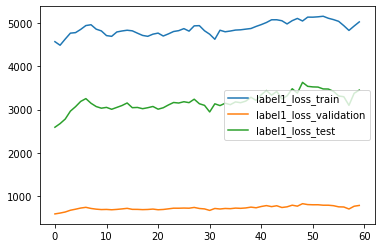

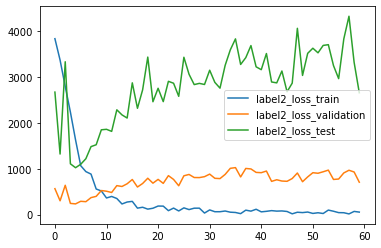

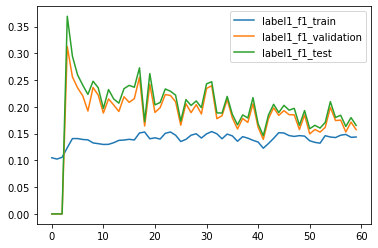

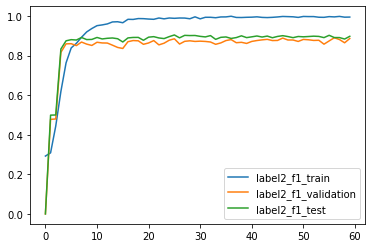

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil
import datetime

OUTPUT_PATH = './checkpoint'
OUTPUT_PATH =os.path.join(OUTPUT_PATH, BERT_PATH[2:])

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)


label1_loss_train_list=[]
label1_loss_validation_list=[]
label1_loss_test_list=[]

label2_loss_train_list=[]
label2_loss_validation_list=[]
label2_loss_test_list=[]

label1_f1_train_list=[]
label1_f1_validation_list=[]
label1_f1_test_list=[]

label2_f1_train_list=[]
label2_f1_validation_list=[]
label2_f1_test_list=[]

best_label2_f1=-1
for epoch in range(N_EPOCHS):
    loss_label1_tr, loss_label2_tr, p_label1_tr, r_label1_tr, f_label1_tr, acc_label1_tr, p_label2_tr, r_label2_tr, f_label2_tr, acc_label2_tr = train(model, train_iterator, optimizer, criterion_tag, criterion_cls, TAG_PAD_IDX, TAG_LOSS_WEIGTH, CLS_LOSS_WEIGTH)
    loss_label1_va, loss_label2_va, p_label1_va, r_label1_va, f_label1_va, acc_label1_va, p_label2_va, r_label2_va, f_label2_va, acc_label2_va = evaluate(model, valid_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)
    loss_label1_te, loss_label2_te, p_label1_te, r_label1_te, f_label1_te, acc_label1_te, p_label2_te, r_label2_te, f_label2_te, acc_label2_te = evaluate(model, test_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)
    print('EPOCH', epoch)
    print('   TRAIN | Label 1 loss:', loss_label1_tr, '; P:', p_label1_tr, '; R:', r_label1_tr, '; F1:', f_label1_tr, '; Acc:', acc_label1_tr)
    print('           Label 2 loss:', loss_label2_tr, '; P:', p_label2_tr, '; R:', r_label2_tr, '; F1:', f_label2_tr, '; Acc:', acc_label2_tr)
    print('   VALID | Label 1 loss:', loss_label1_va, '; P:', p_label1_va, '; R:', r_label1_va, '; F1:', f_label1_va, '; Acc:', acc_label1_va)
    print('           Label 2 loss:', loss_label2_va, '; P:', p_label2_va, '; R:', r_label2_va, '; F1:', f_label2_va, '; Acc:', acc_label2_va)
    print('    TEST | Label 1 loss:', loss_label1_te, '; P:', p_label1_te, '; R:', r_label1_te, '; F1:', f_label1_te, '; Acc:', acc_label1_te)
    print('           Label 2 loss:', loss_label2_te, '; P:', p_label2_te, '; R:', r_label2_te, '; F1:', f_label2_te, '; Acc:', acc_label2_te)
    print(datetime.datetime.now())
    
    label1_loss_train_list.append(loss_label1_tr)
    label1_loss_validation_list.append(loss_label1_va)
    label1_loss_test_list.append(loss_label1_te)
    
    label2_loss_train_list.append(loss_label2_tr)
    label2_loss_validation_list.append(loss_label2_va)
    label2_loss_test_list.append(loss_label2_te)
    
    label1_f1_train_list.append(f_label1_tr)
    label1_f1_validation_list.append(f_label1_va)
    label1_f1_test_list.append(f_label1_te)
    
    label2_f1_train_list.append(f_label2_tr)
    label2_f1_validation_list.append(f_label2_va)
    label2_f1_test_list.append(f_label2_te)
    
    if f_label2_va>best_label2_f1:
        best_label2_f1=f_label2_va
        output_dir = os.path.join(OUTPUT_PATH, 'checkpoint_epoch{}.pt'.format(epoch))
        # clear the content of folder
        for files in os.listdir(OUTPUT_PATH):
            path = os.path.join(OUTPUT_PATH, files)
            try:
                shutil.rmtree(path)
            except OSError:
                os.remove(path)
        # if not os.path.exists(output_dir):
        #     os.makedirs(output_dir)
        torch.save(model.state_dict(), output_dir)

    
    
label1_loss_df = pd.DataFrame(
    {'label1_loss_train': label1_loss_train_list,
     'label1_loss_validation': label1_loss_validation_list,
     'label1_loss_test': label1_loss_test_list
    })
label2_loss_df = pd.DataFrame(
    {'label2_loss_train': label2_loss_train_list,
     'label2_loss_validation': label2_loss_validation_list,
     'label2_loss_test': label2_loss_test_list
    })
label1_f1_df = pd.DataFrame(
    {'label1_f1_train': label1_f1_train_list,
     'label1_f1_validation': label1_f1_validation_list,
     'label1_f1_test': label1_f1_test_list
    })
label2_f1_df = pd.DataFrame(
    {'label2_f1_train': label2_f1_train_list,
     'label2_f1_validation': label2_f1_validation_list,
     'label2_f1_test': label2_f1_test_list
    })
label1_loss_df.plot()
label2_loss_df.plot()
label1_f1_df.plot()
label2_f1_df.plot()

<AxesSubplot:title={'center':'label2 f1'}, xlabel='epochs', ylabel='f1'>

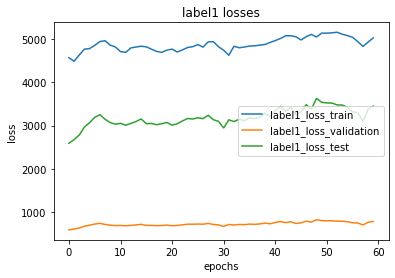

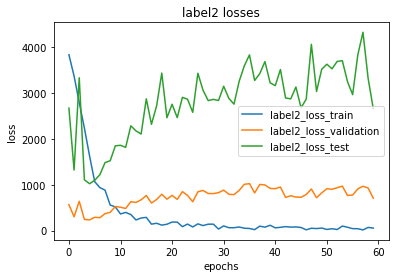

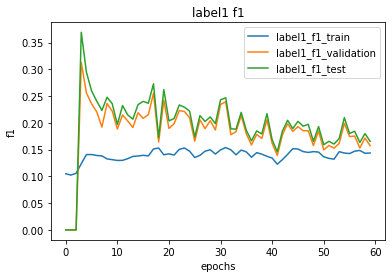

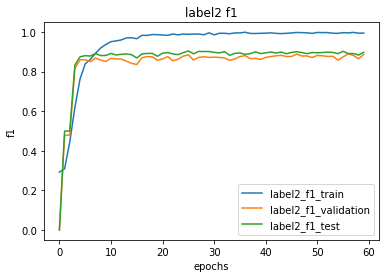

In [22]:
label1_loss_df.plot(title="label1 losses",xlabel="epochs",ylabel="loss")
label2_loss_df.plot(title="label2 losses",xlabel="epochs",ylabel="loss")
label1_f1_df.plot(title="label1 f1",xlabel="epochs",ylabel="f1")
label2_f1_df.plot(title="label2 f1",xlabel="epochs",ylabel="f1")

In [23]:
max(label2_f1_test_list)

0.9041

In [24]:
max(label2_f1_validation_list)

0.89